In [66]:
import numpy as np
import PIL
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import scipy as sc
from scipy.sparse import csr_matrix, identity
from sklearn.metrics.pairwise import euclidean_distances
import cvxpy as cp
import sys
import time

In [72]:
FNAME = 'drapeau.jpg'
img_ref = Image.open(FNAME).convert('RGB')
x = np.array(img_ref)
r_ref, g_ref, b_ref= np.rollaxis(x, axis = -1)
x_ref = np.dstack([r_ref, g_ref, b_ref])
img_ref = Image.fromarray(x_ref, 'RGB')

In [73]:
FNAME = 'drapeau.jpg'
img_src = Image.open(FNAME).convert('RGB')
x = np.array(img_src)
r_src, g_src, b_src = np.rollaxis(x, axis = -1)
x_src = np.dstack([r_src, g_src, b_src])
img_src = Image.fromarray(x_src, 'RGB')

In [74]:
width_ref , length_ref,_= np.shape(x_ref)
width_src, length_src,_ = np.shape(x_src)

N_src = width_src*length_src
N_ref = width_ref*length_ref

In [75]:
###
def find(Y):
    """
    Returns the index sought for finding the root 

    Args : 
        Y : vector we want to project on the unitary simplex (list n x 1)
    """
    for i in range(1,len(Y)): #We start from the largest element
        if np.sum([Y[j] - Y[i] for j in range(i)]) - 1 >= 0:
            return i
    return -1

def root(Y):
    """
    Returns the root of h, i.e the optimal Lagrange multiplier of the kkt conditions
    """
    Y_p = np.sort(Y) #We sort elements from smaller to larger
    Y_p = np.flip(Y_p)
    i = find(Y_p)
    if i >= 0:
        return (np.sum(Y_p[:i]) - 1)/i
    else:
        return (np.sum(Y) - 1)/len(Y)
    
def max(a,b):
    if a<b: 
        return b
    return a

def proj_simplexe(Y): 
    mu = root(Y)
    if mu == 'non feasible':
        return Y
    else:
        return [max(Y[i] - mu, 0) for i in range(len(Y))]

In [76]:
colors_ref = np.empty((width_ref*length_ref,3))
j = 0
for i in range(width_ref*length_ref):
    j = i%length_ref #number of column
    l = i//length_ref #number of row
    colors_ref[i,0] = r_ref[l,j]
    colors_ref[i,1] = g_ref[l,j]
    colors_ref[i,2] = b_ref[l,j]

colors_src = np.empty((width_src*length_src,3))
j = 0
for i in range(width_src*length_src):
    j = i%length_src #width
    l = i//length_src
    colors_src[i,0] = r_src[l,j]
    colors_src[i,1] = g_src[l,j]
    colors_src[i,2] = b_src[l,j] 

Text(0.5, 0, 'N° clusters')

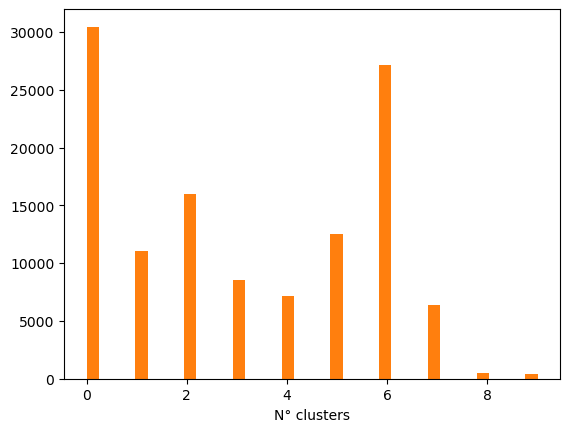

In [78]:
n_src, n_ref = 10, 10 #number of clusters
k_means_color_ref = KMeans(n_clusters = n_ref, random_state = 0, n_init = "auto").fit(colors_ref)
label_ref = k_means_color_ref.labels_
hist_ref = np.histogram(label_ref, bins = n_ref)
plt.hist(label_ref, bins = "auto")

k_means_color_src = KMeans(n_clusters = n_src, random_state = 0, n_init = "auto").fit(colors_src)
label_src = k_means_color_src.labels_
hist_src = np.histogram(label_src, bins = n_src)
plt.hist(label_src, bins = "auto")
plt.xlabel('N° clusters')

In [10]:
X = [i for i in range(10)]
a = [hist_ref[0][i]/N_ref for i in range(n_ref)]
b = [hist_src[0][i]/N_src for i in range(n_src)]

Building of matrix $(C_{i,j})_{i,j \in \llbracket 1,m\rrbracket \times \llbracket 1,n \rrbracket} = (d(\hat{\mathbf{x}}_i^{\text{ref}}, \hat{\mathbf{x}}_j^{\text{src}}))_{i,j \in \llbracket 1,m\rrbracket \times \llbracket 1,n \rrbracket}$ where $\hat{\mathbf{x}}_i^{\text{ref}}$ is the i-th centroid  of the reference image and $\hat{\mathbf{x}}_j^{\text{src}}$ is the j-th centroid of the source image.

In [11]:
cluster_center_ref = k_means_color_ref.cluster_centers_/256 #scaling
cluster_center_src = k_means_color_src.cluster_centers_/256 #scaling

def dist(x,y):
    """
    return euclidian distance between x and y
    Outputs : 
        ||x - y||^2
    """
    return np.dot(x - y, x - y)

c = np.empty((n_ref*n_src))
for i in range(n_ref): #Nombre de lignes
    for j in range(n_src): #Nombre de colonnes
        c[i + j * n_ref] = dist(cluster_center_src[j], cluster_center_ref[i])

c_p = euclidean_distances(cluster_center_ref, cluster_center_src, squared=True)

### Linear programming for regular OT

Set up for linear programming of regular OT, in particular $t \in \mathbf{R}^{nm}$, $A \in \mathcal{M}_{n + m,nm}(\mathbf{R})$ , and $d \in \mathbf{R}^{n + m}$. The goal is here to solve : 
$$
\min_{t \in \mathbf{R}^{nm}} c^{\top}t \\
s.t \quad At = d \\
\quad \quad t \geq 0
$$

PENSEZ A PARLER DU PROBLEME DE SCALING NUMERIQUE (QUE JE NE CONNAISSAIS PAS AVANT). Autre idée : utiliser des matrices sparses, elles sont apparamment compatibles avec CVXPY

To put it into a standard linear programming, I am going to convert columnwise the matrix into vectors i.e $T_{i,j} = t_{i + (j - 1)m}$, where $T \in \mathbf{R}^{ m  \times n}$ and $t \in \mathbf{R}^{nm}$. The constraints also have to be adapted to the vector formalism and put into the form $At = d$. In the exact same way, the cost matrix is transformed into a matrix : $(C_{i,j})_{i,j \in \llbracket 1,m\rrbracket \times \llbracket 1,n \rrbracket} = (c_{i + (j - 1)m})_{i + (j - 1)m \in \llbracket 1,nm\rrbracket }$. m is the number of cluster in the reference image, and n is the number of cluster in the source image.

In [12]:
def equality(m,n):
    """
    Build here all the equality constraints for regular OT
    Args : 
        m : number of constraints (i.e number of cluster colors) for reference image (int n_ref)
        n : number of constraints (i.e number of cluster colors) for source image (int n_ref)

    Output:
        Matrix for first set of constraints A1 and second set of constraints
    """
    A1 = np.zeros((m,n*m)) #equality for a
    A2 = np.zeros((n,n*m)) #equality for b

    for j in range(m):
        for i in range(0,n*m,m):
            A1[j, j + i] = 1
    k = 0
    for j in range(n):
        A2[j,k: k + m] = 1
        k += m
    return A1,A2

def mean_vector(T,y,n_src,n_ref):
    """
    new color after transport of y with T
    Args:
        T : transport plan (list nm)
        y : cluster of the source (or reference) image (int)
        n_src : number of cluster of the source image (int)
        n_ref : number of cluster of the reference image (int)
    Outputs : 
        solution of the barycentric problem projection
    """
    x = np.empty((n_ref,3))
    for i in range(n_ref):
        t = 0
        for j in range(n_src):
            t += T[i + j*n_ref]*y[j]
        x[i] = t/np.sum([T[i + j*n_ref] for j in range(n_src)])
    return x

def mean_tensor(T,y,n_src,n_ref):
    """
    new color after transport of y with T
    Args:
        T : transport plan (list n x m)
        y : cluster of the source (or reference) image (int)
        n_src : number of cluster of the source image (int)
        n_ref : number of cluster of the reference image (int)
    Outputs : 
        solution of the barycentric problem projection
    """
    x = np.empty((n_ref,3))
    for i in range(n_ref):
        for j in range(n_src):
            x[i] += T[i,j]*y[j]
        x[i] /= np.sum(T[i,:])
    return x

In [13]:
d = np.concatenate((a,b))
t = cp.Variable(n_ref*n_src)
A1,A2 = equality(n_ref,n_src)
A = np.concatenate((A1,A2))

At first, I had a bad way of scaling. The right one is to scale the centers of clusters and not divide c by an arbitraty constant.

In [14]:
prob = cp.Problem(cp.Minimize(c.T@t),
                 [A @ t == d, t >= 0])
prob.solve(solver = 'ECOS')
# Print result.
print("\n The optimal value is", prob.value)
print("A solution t is")
print(t.value)


 The optimal value is 0.04712733932031485
A solution t is
[-7.76034606e-16  1.30526745e-14 -1.62398315e-17 ... -1.20671657e-15
 -1.23944192e-15 -8.42839752e-16]


In [15]:
for i in range(len(t.value)):
    if t.value[i] < 1e-10:
        t.value[i] = 0

In [16]:
def from_vector_to_tensor(t,m,n):
    """
    Transform a vector of size mn into a m times n tensor columnwise like it is done for t and c
    Args : 
        t : vector to transform
        m : number of cluster of reference image
        n : number of cluster of source image
    Output : 
    The square matrix equivalent to t in columnwise setting
    """
    T = np.empty((m,n))
    for i in range(m*n):
        j = i//m
        l = i%m
        T[l,j] = t[i]
    return T
T = from_vector_to_tensor(t.value, n_ref, n_src)
C = from_vector_to_tensor(c,n_ref, n_src)

In [17]:
sparsity = (n_ref*n_src - len(T[T > 0]))/(n_ref*n_src) #Percentage of sparsity
sparsity

0.9801

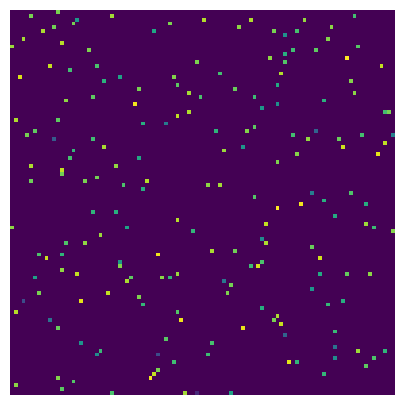

In [18]:
plt.figure(figsize=(5,5))
plt.imshow(np.log(T+1e-5))
plt.axis('off');

Compute the new clusters thanks to 'mean' function

In [19]:
cluster_center_new = mean_vector(t.value,cluster_center_src,n_src,n_ref)

In [20]:
image_n = cluster_center_new[label_ref]

In [21]:
image_new = np.zeros((width_ref, length_ref, 3))
for i in range(width_ref):
    for j in range(length_ref):
        image_new[i,j] = image_n[i*length_ref + j] #row-wise

(-0.5, 399.5, 299.5, -0.5)

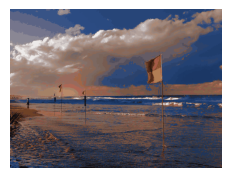

In [22]:
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(221)
ax.imshow(image_new)
ax.axis("off")

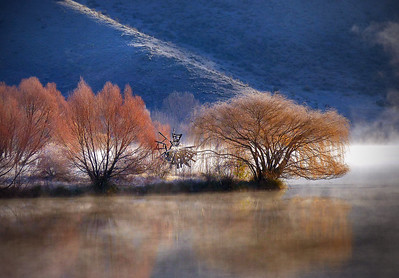

In [23]:
img_src

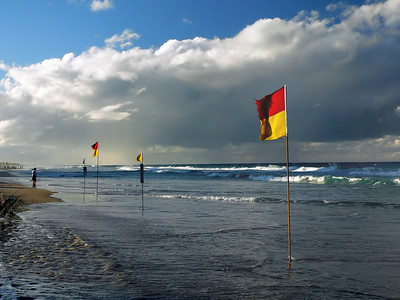

In [24]:
img_ref

Compute the sparsity of the function

In [25]:
sparsity = (n_ref*n_src - len(T[T > 0]))/(n_ref*n_src) #Percentage of sparsity
sparsity

0.9801

To have a primal with strong convexity, one adds a strongly convex function $\Omega$, function of the column of T.
It then becomes : 
$$
OT_{\Omega}(a,b) = \min\limits_{P \in \mathcal{U}(a,b)} \langle P,C \rangle + \sum\limits_{j = 1}^n \Omega(\mathbf{t}_j)
$$
We then want to solve it via Sinkhorn algorithm in the case of entropic regularization.

entropy break down the rule of natural sparsity : This
implies in particular that the resulting P matrix is sparse, for instance one can show that there are always
solutions with less than n + m − 1 non-zero elements
Speeding Up Sinkhorn’s Iterations 
Parallel and GPU friendly computation

In [62]:
gamma_L = [1e-3,2e-3,3e-3,5e-3,8e-3,1e-2,5e-2,5e-1,1e-1]
n_iter = 0
def sinkhorn(C, u_init, v_init, eps, gamma):
    """
    Compute Sinkhorn algorithm
    Args:
        C : cost matrix (list m x n)
        u_init : initial vector for u (list m)
        v_init : initial vector for v (list n)
        eps : value under which one break the loop
    Outputs : 
        Transport plan and optimal objective function, error to the true transportation plan T*, number of iteration
    """
    K = np.exp(-C/gamma) #definition of the Gibbs Kernel
    P = np.diag(u_init) @ K @ np.diag(v_init)
    p_criteria = 2*P
    u = u_init
    v = v_init
    Error = []
    n_iter = 0
    while (np.abs((np.trace(P.T @ P) - np.trace(p_criteria.T @ p_criteria)))/np.trace(p_criteria.T @ p_criteria) > eps):

        v_p = np.dot(K,v)
        u = np.array([a[i]/v_p[i] for i in range(n_ref)])

        u_p = np.dot(np.transpose(K),u)
        v = np.array([a[i]/u_p[i] for i in range(n_ref)])

        p_criteria = P
        P = np.diag(u) @ K @ np.diag(v)
        Error += [np.linalg.norm(P - T)]
        n_iter += 1
    return P, np.trace(P.T @ C), Error, n_iter

In [63]:
def from_tensor_to_vector(T,m,n):
    """
    Transform a vector of size mn into a m times n tensor columnwise like it is done for t and c
    Args : 
        t : vector to transform
        m : number of cluster of reference image
        n : number of cluster of source image
    Output : 
    The square matrix equivalent to t in columnwise setting
    """
    t = np.empty((n*m))
    for i in range(n*m):
        j = i//m
        l = i%m
        t[i] = T[l,j]
    return t

0.029334306716918945
0.016376018524169922
0.007218360900878906
0.036338090896606445
0.0258333683013916
0.020913362503051758
0.018347501754760742
0.006028890609741211
0.0


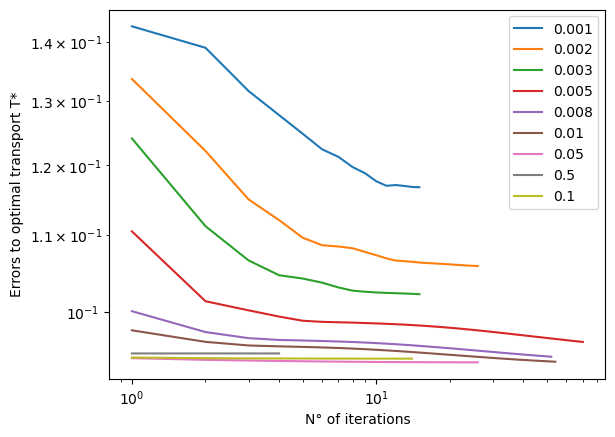

In [70]:
n_iter = 0
u_init = np.ones((n_ref))
v_init = np.ones((n_src))
eps = 0.0001
Time_sinkhorn = []
for gamma in gamma_L:
    start = time.time()
    P, objective, Error, n_iter = sinkhorn(C, u_init, v_init, eps, gamma)
    end = time.time()
    print(-start + end)
    Time_sinkhorn += [end - start]
    p = from_tensor_to_vector(P,n_ref, n_src)
    N = np.linspace(1,n_iter,n_iter)
    plt.loglog(N,Error, label = str(gamma))
    plt.xlabel('N° of iterations')
    plt.ylabel('Errors to optimal transport T*')
plt.legend()

In [28]:
p = from_tensor_to_vector(P,n_ref, n_src)

cluster_center_ent = mean_vector(p,cluster_center_src,n_src,n_ref)

Text(0, 0.5, 'Errors to optimal transport T*')

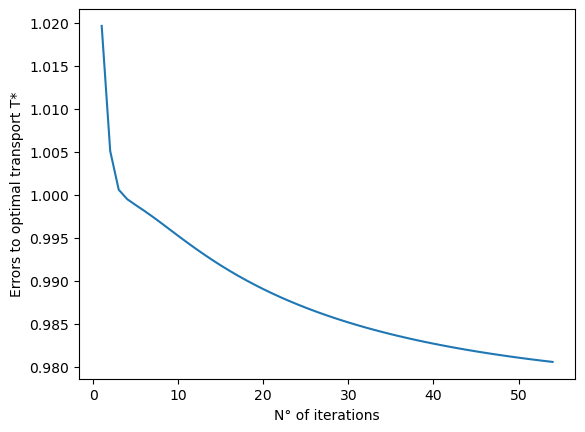

In [707]:
N = np.linspace(1,n_iter,n_iter)
plt.plot(N,Error)
plt.xlabel('N° of iterations')
plt.ylabel('Errors to optimal transport T*')

In [691]:
image_e = cluster_center_ent[label_ref]

In [692]:
image_ent = np.zeros((width_ref, length_ref, 3))
for i in range(width_ref):
    for j in range(length_ref):
        image_ent[i,j] = image_e[i*length_ref + j] #row-wise

(-0.5, 399.5, 299.5, -0.5)

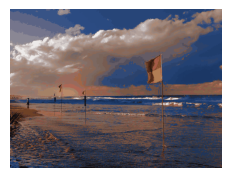

In [693]:
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(221)
ax.imshow(image_new)
ax.axis("off")

In [694]:
sparsity = (n_ref*n_src - len(P[P > 0]))/(n_ref*n_src) #Percentage of sparsity
sparsity

0.0919

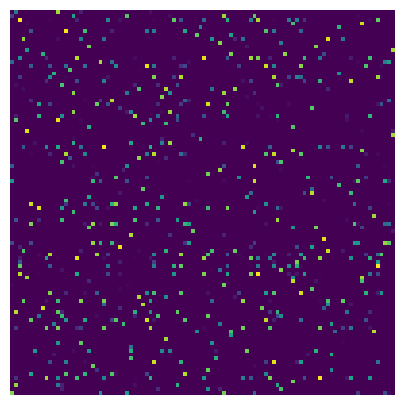

In [695]:
plt.figure(figsize=(5,5))
plt.imshow(np.log(P+1e-5))
plt.axis('off');